In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
import talib as ta

### S&P 500 stocks

In [2]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


### Get the Fundamentals

In [3]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3748113678336,40.715927,29.846722,65.824265,6.09,8.31,3.767,0.1612,1.240,0.62,0.244208,47771261,9.666,0.23971
ABBV,306103975936,60.145832,14.237221,50.753002,2.88,12.13,3.413,2.1359,0.613,4.13,0.125839,5880703,6.703,0.09223
ABT,197494292480,34.609420,22.067415,4.962735,3.29,5.16,22.944,0.6565,0.722,1.65,0.051013,5043612,4.985,0.13992
ACN,225079377920,31.542030,25.657955,7.961849,11.42,14.07,45.242,0.4510,1.245,1.36,0.061594,2482220,3.503,0.11194
ADBE,208932126720,38.369442,20.576773,14.521339,12.37,20.55,32.685,0.0000,1.299,0.12,-0.059370,3043996,11.488,0.25588


In [4]:
# Normalised the data
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.988552,0.009175,0.106324,2.382655,-0.218056,-0.209777,-0.100823,-0.212221,0.713554,-1.017199,0.076833,1.284584,0.867403,0.653144
ABBV,-0.113123,0.199479,-0.238558,1.723954,-0.412880,-0.033784,-0.100832,0.372456,-0.923289,1.050662,-0.282748,-0.262662,0.301447,-0.484589
ABT,-0.274102,-0.050635,-0.065555,-0.277347,-0.387996,-0.354902,-0.100385,-0.065571,-0.638734,-0.410391,-0.510056,-0.293580,-0.026705,-0.116685
ACN,-0.233216,-0.080678,0.013776,-0.146268,0.105435,0.055594,-0.099875,-0.126416,0.726606,-0.581240,-0.477914,-0.388186,-0.309779,-0.332536
ADBE,-0.257149,-0.013808,-0.098490,0.140419,0.163093,0.354138,-0.100162,-0.259950,0.867579,-1.311766,-0.845379,-0.367437,1.215420,0.777887


In [5]:
# Save it to a csv file
normalized_fundamentals.to_csv("../data/SP100/fundamentals.csv")

### Historical data

In [6]:
values = [
    yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
    stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()
    
    # Log returns
    stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
    stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
    stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
    stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
    stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21
    
    # Normalizing the standard deviation
    stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
    stock_values["ALR1W"] /= stock_values["ALR1W"].std()
    stock_values["ALR2W"] /= stock_values["ALR2W"].std()
    stock_values["ALR1M"] /= stock_values["ALR1M"].std()
    stock_values["ALR2M"] /= stock_values["ALR2M"].std()
    
    # RSI calculation
    stock_values["RSI"] = ta.RSI(stock_values["Close"], timeperiod=14) / 100
    
    # MACD calculation
    macd, macd_signal, macd_hist = ta.MACD(
        stock_values["Close"], 
        fastperiod=12, 
        slowperiod=26, 
        signalperiod=9
    )
    stock_values["MACD"] = macd
    
    # Drop unnecessary columns
    stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

# Concatenate the results into a single DataFrame
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)


Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2020-02-14 00:00:00-05:00  78.945244  -1.717131        0.012339   
       2020-02-18 00:00:00-05:00  77.499710  -1.751778       -0.927029   
       2020-02-19 00:00:00-05:00  78.622124  -1.724876        0.721292   
       2020-02-20 00:00:00-05:00  77.815559  -1.744207       -0.517268   
       2020-02-21 00:00:00-05:00  76.054199  -1.786423       -1.148492   
       2020-02-24 00:00:00-05:00  72.441582  -1.873010       -2.441224   
       2020-02-25 00:00:00-05:00  69.987846  -1.931821       -1.728563   
       2020-02-26 00:00:00-05:00  71.098106  -1.905210        0.789522   
       2020-02-27 00:00:00-05:00  66.450539  -2.016602       -3.391165   
       2020-02-28 00:00:00-05:00  66.411667  -2.017534       -0.029353   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2020-02-14 00:00:00-05:00  0.375774  0.891135  0.537198  1.441355   
       2020-02-18 00:00:00-05:00 -0.196117  0.616552  0.169253  1.138491   
       2020-02-19 00:00:00-05:00  0.307105  0.300578  0.209332  1.244552   
       2020-02-20 00:00:00-05:00 -0.524958 -0.021182  0.167552  1.176899   
       2020-02-21 00:00:00-05:00 -0.912862 -0.623824 -0.147209  0.972770   
       2020-02-24 00:00:00-05:00 -2.117583 -1.234422 -0.783311  0.574749   
       2020-02-25 00:00:00-05:00 -2.511143 -1.918637 -1.158916  0.142104   
       2020-02-26 00:00:00-05:00 -2.477642 -1.538261 -0.616612  0.268439   
       2020-02-27 00:00:00-05:00 -3.888750 -3.127997 -1.752718 -0.476897   
       2020-02-28 00:00:00-05:00 -3.339243 -3.013470 -2.006129 -0.478653   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2020-02-14 00:00:00-05:00  0.616398  1.705852  
       2020-02-18 00:00:00-05:00  0.549690  1.539877  
       2020-02-19 00:00:00-05:00  0.587059  1.481828  
       2020-02-20 00:00:00-05:00  0.551633  1.355121  
       2020-02-21 00:00:00-05:00  0.483076  1.099898  
       2020-02-24 00:00:00-05:00  0.379029  0.599216  
       2020-02-25 00:00:00-05:00  0.327442  0.004377  
       2020-02-26 00:00:00-05:00  0.369273 -0.373148  
       2020-02-27 00:00:00-05:00  0.288409 -1.035424  
       2020-02-28 00:00:00-05:00  0.287841 -1.545601

In [7]:
# Save the dataframe "values" to cvs file
values.to_csv("../data/SP100/values.csv")

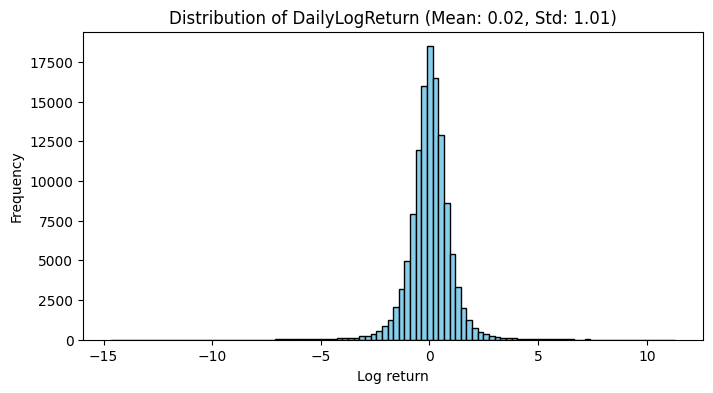

In [8]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

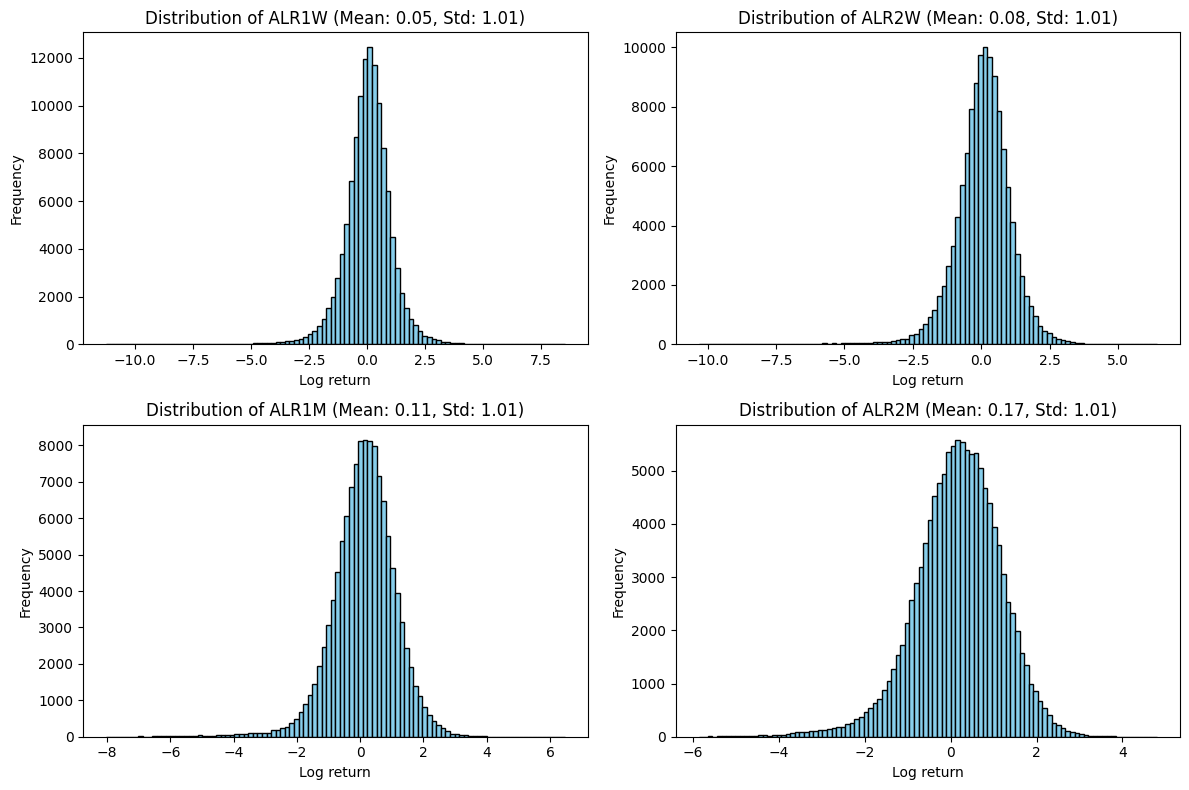

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

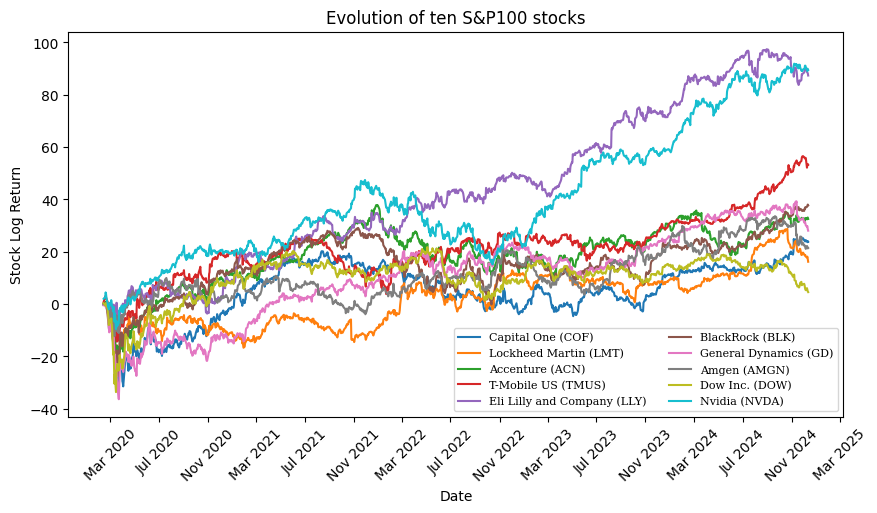

In [10]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()